In [1]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

from torchvision.datasets import MNIST
import torchvision.transforms as T

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer




## Problem One: Exploring Shakespeare's Plays with PCA (45 pts)

In this problem, we will use Principal Components Analysis to look at Shakespeare's plays, as
we discussed with a very different play/movie in lecture.  Along the way, we shall use the tokenizer and the TF-IDF vectorizer from `sklearn,`
a common machine learning library.

Note: There is a library for text analysis in Pytorch called `Torchtext`, however, in my view this will less well-developed and less well-supported than the rest of Pytorch, so we shall use `sklearn` for this problem.



### Part A:  Reading and exploring the data (5 pts)

The cells below read in three files and convert them to `numpy` arrays (I prefer to work with the arrays rather than with `pandas` functions, but it is your choice).  

1. The file `shakespeare_plays.csv` contains lines from William Shakespeare’s plays. The second column of the file contains the name of
the play, the third the name of the player (or the indication `<Stage Direction>`, and the fourth
the line spoken:


2. The file `play_attributes.csv` stores the genres and chronology of Shakepeare's plays; the first column is the name of the play, the second the genre, and the third its order in a chronological listing of when it was first performed. The plays are in the same (arbitrary) order as in the first file.



3. The file `player_genders.csv` stores the name of a major character (defined somewhat arbitrarily as one whose total lines contain more than 1400 characters) in the first column and their gender in the second.



**To Do:**   For each of the arrays, print out the the `shape` and the first line.


In [2]:
plays_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/shakespeare_plays.csv').to_numpy()

player_genders_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/player_genders.csv').to_numpy()

play_attributes_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/play_attributes.csv').to_numpy()


In [15]:
print(plays_array.shape)
print(plays_array[0])

(111582, 4)
[1 'Henry IV Part 1' '<Stage Direction>' 'ACT I']


In [4]:
print(player_genders_array.shape)
print(player_genders_array[0])

(398, 2)
['AARON' 'male']


In [5]:
print(play_attributes_array.shape)
print(play_attributes_array[0])

(36, 3)
['Henry IV Part 1' 'History' 15]


### Part B: Visualizing the Plays (8 pts)

1. Create an array containing 36 strings, each being the concatenation of all lines spoken.   Be sure to NOT include stage directions!  You may wish to create an appropriate dictionary as an intermediate step.

2. Create a document-term matrix where each row represents a play and each column represents a term used in that play. Each entry in this matrix represents the number of times a particular word (defined by the column) occurs in a particular play (defined by the row). Use `CountVectorizer` in `sklearn` to create the matrix. Keep the rows in the same order as in the original files in order to associate play names with terms correctly.

3. From this matrix, use `TruncatedSVD` in `sklearn` to create a 2-dimensional representation of each play. Try to make it as similar as possible to the illustration below, including (i) appropriate title, (ii) names of each play, followed by its chronological order, and (iii) different colors for each genre. Use a `figsize` of `(8,8)` and a `fontsize` of `6` to provide the best visibility. You can follow the tutorial [here](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/) to create the visualization (look at the "PCA" part).

4. Now do the same thing all over again, but with TF-IDF counts (using `TFIDFVectorizer` in `sklearn`).


5. Answer the following in a few sentences:  What plays are similar to each other? Do they match the grouping of Shakespeare’s plays into comedies, histories, and tragedies here?  Which plays are outliers (separated from the others in the same genre)?  Did one of TF or TF-IDF provided the best insights?


In [6]:
#Create dictionaries with play names as keys and concatenate all lines into
#a single string for that play's value

play_lines=defaultdict(lambda: '')
for (_,pr,pn,ln) in plays_array:
  if pn=='<Stage Direction>':
    continue
  else:
    play_lines[pr]=' '.join([play_lines[pr],ln])#default dictionary with play names and lines spoken in them

#Play names array
play_names_array=list(play_lines.keys())#names array
play_strings_array=list(play_lines.values())# strings array

In [7]:
vectorizer=CountVectorizer()
doc_word_matrix=vectorizer.fit_transform(play_strings_array)

In [8]:
pca=TruncatedSVD(n_components=2)
result=pca.fit_transform(doc_word_matrix)

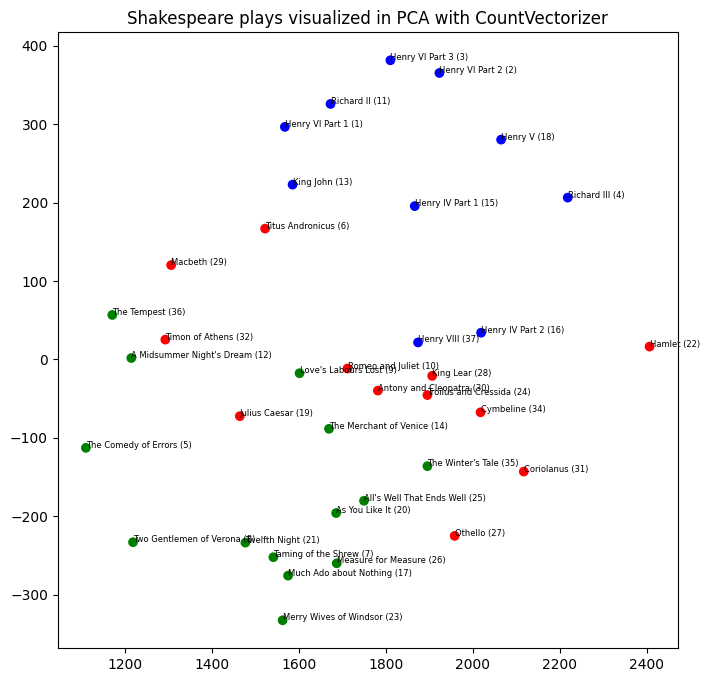

In [9]:
genres= play_attributes_array[:,1]
chronology= play_attributes_array[:,2]

plt.figure(figsize=(8, 8))
plt.title("Shakespeare plays visualized in PCA with CountVectorizer")
colors={'History':'b','Tragedy':'r','Comedy':'g'}
point_colors = [colors[genre] for genre in genres]
plt.scatter(result[:, 0], result[:, 1], c=point_colors)#plot

# Annotate the points with play names and chronological order
for i in range(len(play_names_array)):
    plt.annotate(f"{play_names_array[i]} ({chronology[i]})", (result[i, 0], result[i, 1]), fontsize=6)#annotation

plt.show()

**Same experiment with TF-IDF Vectorizer**

In [10]:
vectorizertfidf=TfidfVectorizer()
doc_word_matrixtfidf=vectorizertfidf.fit_transform(play_strings_array)

In [11]:
pcatfidf=TruncatedSVD(n_components=2)
resulttfidf=pcatfidf.fit_transform(doc_word_matrixtfidf)

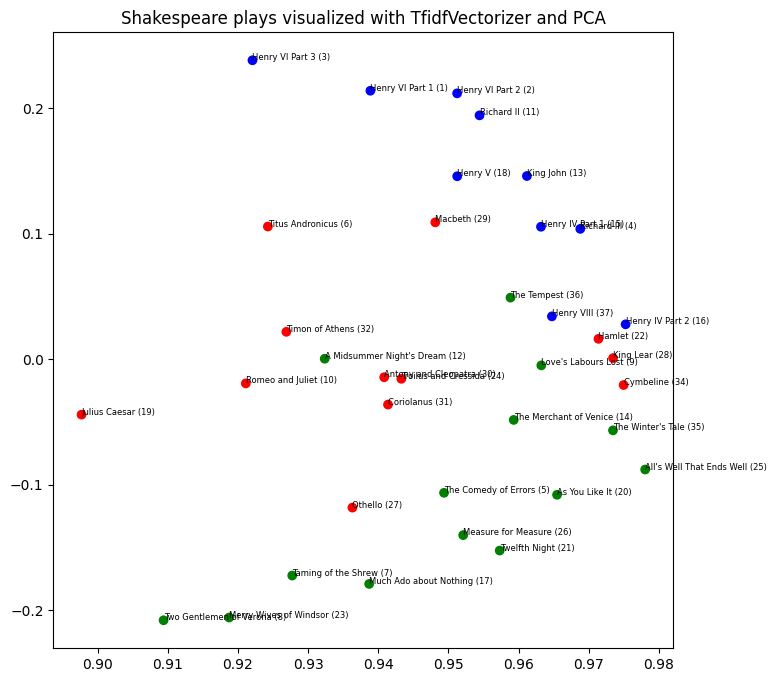

In [12]:
genres= play_attributes_array[:,1]#genres array for coloring
chronology= play_attributes_array[:,2]#chronology array

plt.figure(figsize=(8, 8))
plt.title("Shakespeare plays visualized with TfidfVectorizer and PCA")
colors={'History':'b','Tragedy':'r','Comedy':'g'}
point_colors = [colors[genre] for genre in genres]
plt.scatter(resulttfidf[:, 0], resulttfidf[:, 1], c=point_colors)#plot

# Annotate the points with play names and chronological order
for i in range(len(play_names_array)):
    plt.annotate(f"{play_names_array[i]} ({chronology[i]})", (resulttfidf[i, 0], resulttfidf[i, 1]), fontsize=6)#annotation

plt.show()

Answers:

For both the plots, it is clearly visible that the plays of the same category are clustered together and hence it can be stated that they are similar to each other.

They do match the grouping of Shakespeare's plays.

Hamlet can be considered as an outlier in the first case and in the second case Julius Caeser can be considered. Rest all plays are close to each other.

CountVectorizer and Tf-Idf both gave good insights about the grouping of the plays.

### Part C: Visualizing the Players (8 pts)

Now you must repeat this same kind of visualization, but instead of visualizing plays, you must visualize players.
The process will be essentially the same, starting with an array of strings representing the lines spoken by each player. Use one of TF or TF-IDF, and use different colors for the genders.

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible.

Again, comment on what you observe (it will not be as satisfying as the previous part).

In [16]:
player_lines=defaultdict(lambda: '')
for (_,pr,pn,ln) in plays_array:
  if pn=='<Stage Direction>':
    continue
  else:
    player_lines[pn]=' '.join([player_lines[pn],ln])#dictionary of lines spoken by each user

#Play names array
player_names_array=list(player_lines.keys())#player names
player_strings_array=list(player_lines.values())#player lines
#player_names_array

In [19]:
player_genders=defaultdict(lambda: '')
for (pl,g) in player_genders_array:
    player_genders[pl]=g#player genders dictionary

In [21]:
#Count Vectorizer Implementation
vectorizer=CountVectorizer()
doc_word_matrix_player=vectorizer.fit_transform(player_strings_array)
pca_player=TruncatedSVD(n_components=2)
result_player=pca_player.fit_transform(doc_word_matrix_player)

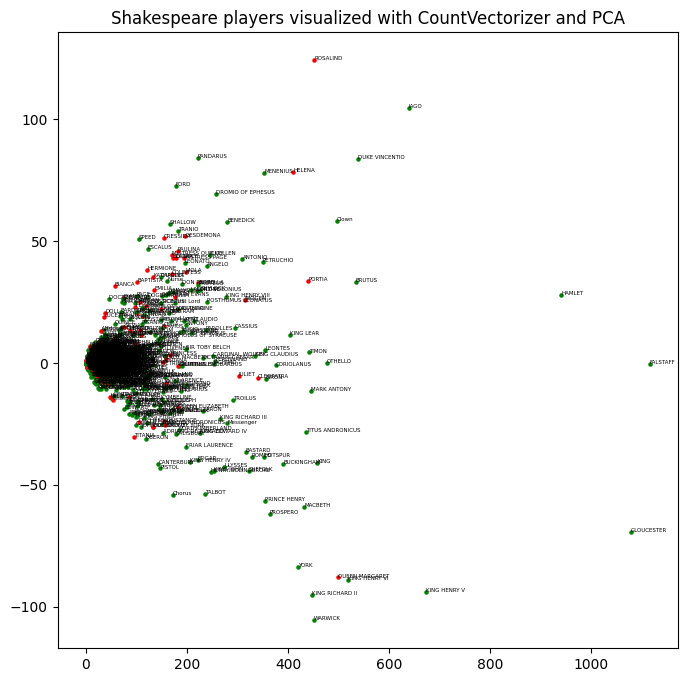

In [22]:
genders= player_genders_array[:,1]

plt.figure(figsize=(8, 8))
plt.title("Shakespeare players visualized with CountVectorizer and PCA")
for i in range(len(player_names_array)):
    if player_genders[player_names_array[i]]=="male":
      color='g'
    elif player_genders[player_names_array[i]]=="female":
      color='r'
    plt.scatter(result_player[i, 0], result_player[i, 1], c=color,s=5)#plot

# Annotate the points with play names and chronological order
for i in range(len(player_names_array)):
    plt.annotate(f"{player_names_array[i]}", (result_player[i, 0], result_player[i, 1]), fontsize=4)#annotation

plt.show()

In [24]:
#Tf-Idf Vectorizer implementation
doc_word_matrix_player_tfidf=vectorizertfidf.fit_transform(player_strings_array)
result_player_tfidf=pca_player.fit_transform(doc_word_matrix_player_tfidf)

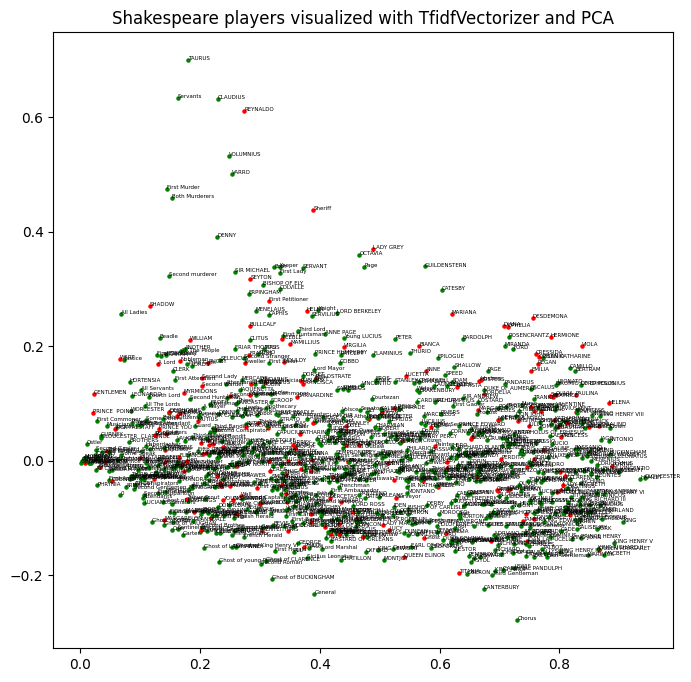

In [25]:
genders= player_genders_array[:,1]

plt.figure(figsize=(8, 8))
plt.title("Shakespeare players visualized with TfidfVectorizer and PCA")
for i in range(len(player_names_array)):
    if player_genders[player_names_array[i]]=="male":
      color='g'
    elif player_genders[player_names_array[i]]=="female":
      color='r'
    plt.scatter(result_player_tfidf[i, 0], result_player_tfidf[i, 1], c=color,s=5)#plot

# Annotate the points with play names and chronological order
for i in range(len(player_names_array)):
    plt.annotate(f"{player_names_array[i]}", (result_player_tfidf[i, 0], result_player_tfidf[i, 1]), fontsize=4)#annotation

plt.show()

For the players, the grouping are not clear.

For the CountVectorizer implementation all the female players are clustered together better, the male players cluster is still spread more. Both has few outliers. But both male and female majority are clustered around the same area.

For TfIdf male and female clusters are mixed with each other and there is no clear distinction between them.

### Part D:  DIY Word Embeddings (8 pts)

In this part you will create a word-word matrix where each row (and each column) represents a word in the vocabulary.
Each entry in this matrix represents the number of times a particular word (defined by the row) co-occurs with another
word (defined by the column) in a sentence (i.e., line in `plays`). Using the row word vectors, create a document-term matrix which represents
a play as the average of all the word vectors in the play.

Display the plays using `TruncatedSVD` as you did previously.  

Again, comment on what you observe: how different is this from the first visualization?

**Notes:**  

1. Remove punctuation marks .  ,  ;  :  ?  ! but leave single quotes.
2. One way to proceed is to create a nested dictionary mapping each word to a dictionary of the frequency of words that occur in the same line, then from this to create the sparse matrix which is used to create the aerage document-term matrix which is input to `TruncatedSVD`.
3. If you have trouble with the amount of memory necessary, you may wish to eliminate "stop words" and then isolate some number (say, 5000) of the remaining most common words, and build your visualization on that instead of the complete vocabulary.


In [26]:
#Word-word dictionary creation
pattern = r"[.,;:?!]+"
word_word_dict=defaultdict(lambda: defaultdict(lambda:0))
for (_,pr,pn,ln) in plays_array:
  if pn=='<Stage Direction>':
    continue
  else:
    line=ln.lower()#converted to lower
    cleaned_line=re.sub(pattern,"",line)#punctuation removal
    split_line=cleaned_line.split()
    for i in range(len(split_line)):
      for j in range(len(split_line)):
        if i!=j:
          word_word_dict[split_line[i]][split_line[j]]+=1
        else:
          word_word_dict[split_line[i]][split_line[j]]+=0


In [28]:
#conversion to sparse matrix
from scipy.sparse import lil_matrix
vocabulary = set(word_word_dict.keys())#word vocabulary
word_to_index = {word: idx for idx, word in enumerate(vocabulary)}#word index mapping
word_word_matrix = lil_matrix((len(vocabulary), len(vocabulary)), dtype=np.int32)
for word, co_occurrences in word_word_dict.items():
    for co_word, count in co_occurrences.items():
        word_word_matrix[word_to_index[word], word_to_index[co_word]] = count#assigning matrix position with the count
word_word_matrix=word_word_matrix.tocsr()#converting to csr sparse matrix


In [31]:
len(vocabulary)#Number of words from set

30432

In [30]:
vectorizer=CountVectorizer()
doc_mat=vectorizer.fit_transform(play_strings_array)
vocab=vectorizer.get_feature_names_out()
len(vocab)#Number of unique words from CountVectorizer

22698

Since the above two values are different just moving forward with the set count

In [32]:
#Document Term array creation
doc_term_array = [[0 for _ in range(len(vocabulary))] for _ in range(36)]
for pl in range(len(play_names_array)):
  line=play_lines[play_names_array[pl]]
  line=line.lower()
  line=re.sub(pattern,"",line)
  count=len(line.split())
  for i in line.split():
    doc_term_array[pl]+=word_word_matrix[word_to_index[i]].toarray()#Vector addition for each word
  doc_term_array[pl]=doc_term_array[pl]/count# Mean vector for each play




In [33]:
doc_term_array_final = [sublist[0] for sublist in doc_term_array]#Putting in the same shape as play_lines

In [34]:
pca_DIY=TruncatedSVD(n_components=2)
result_DIY=pca.fit_transform(doc_term_array_final)

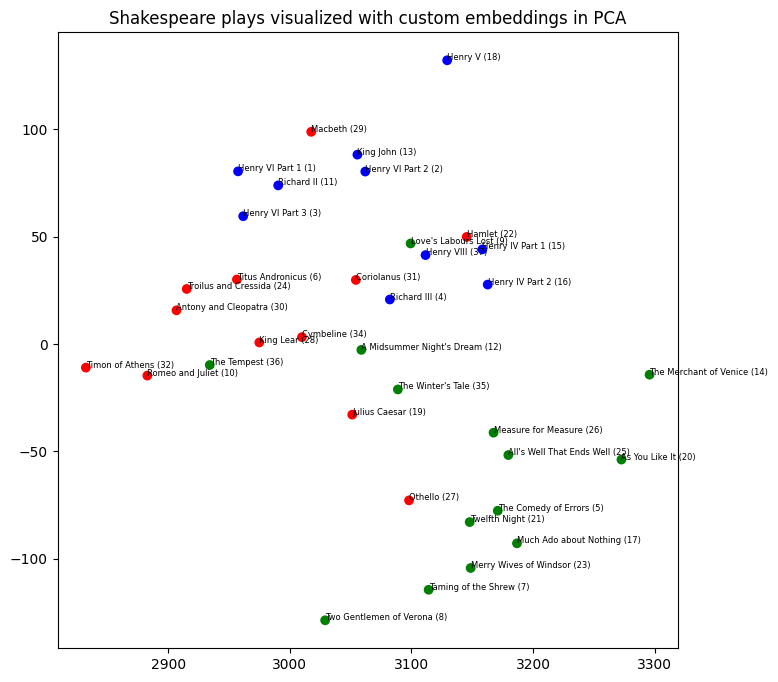

In [35]:
plt.figure(figsize=(8, 8))
plt.title("Shakespeare plays visualized with custom embeddings in PCA")
colors={'History':'b','Tragedy':'r','Comedy':'g'}
point_colors = [colors[genre] for genre in genres]
plt.scatter(result_DIY[:, 0], result_DIY[:, 1], c=point_colors)

# Annotate the points with play names and chronological order
for i in range(len(play_names_array)):
    plt.annotate(f"{play_names_array[i]} ({chronology[i]})", (result_DIY[i, 0], result_DIY[i, 1]), fontsize=6)

plt.show()

Though this visualisation also has understandable groupings the regions of grouping in the plot are very different and also there are many mixed genre instances in the middle region which enters other cluster's area. It is not a better grouping than first one.

### Part E:  Visualizing the Plays using Word2Vec Word Embeddings (8 pts)

Now we will do the play visualization using word embeddings created by Gensim's `Word2Vec`, which can create word embeddings just as you did in the previous part, but using better algorithms.

You can read about how to use `Word2Vec` and get template code here:

https://radimrehurek.com/gensim/models/word2vec.html

I strongly recommend you follow the directions for creating the model, then using `KeyedVectors` to
avoid recomputing the model each time.

Experiment with the `window` (say 5) and the `min_count` (try in the range 1 - 5) parameters to get the best results.

Display the plays using `PCA` instead of `TruncatedSVD`.  

Again, comment on what you observe: how different is this from the other visualizations?


In [36]:
#Creating a list of all lines in the play split into words
split_lines_play=[]
for (i,pr,pn,ln) in plays_array:
  if pn=='<Stage Direction>':
    continue
  else:
    ln=ln.lower()#lowercase
    ln=re.sub(pattern,"",ln)#removing punctuation
    split_lines_play.append(ln.split())

In [51]:
from gensim.models import Word2Vec
model = Word2Vec(split_lines_play, min_count=1,window=5)#Word2Vec model with min_count=1 and window=5
#words=model.wv.index_to_key

In [53]:
#Doc-term array with word2vec
doc_term_array_wv = np.zeros((36, 100))
for pl in range(len(play_names_array)):
  line=play_lines[play_names_array[pl]]
  line=line.lower()
  line=re.sub(pattern,"",line)
  count=len(line.split())
  for i in line.split():
    doc_term_array_wv[pl]+=model.wv[i]
  doc_term_array_wv[pl]=doc_term_array_wv[pl]/count
  #else:
    #print(play_lines[play_names_array[pl]])

In [54]:
pcawv = PCA(n_components=2)#using PCA not TFIDF
resultwv = pcawv.fit_transform(doc_term_array_wv)
# create a scatter plot of the projection


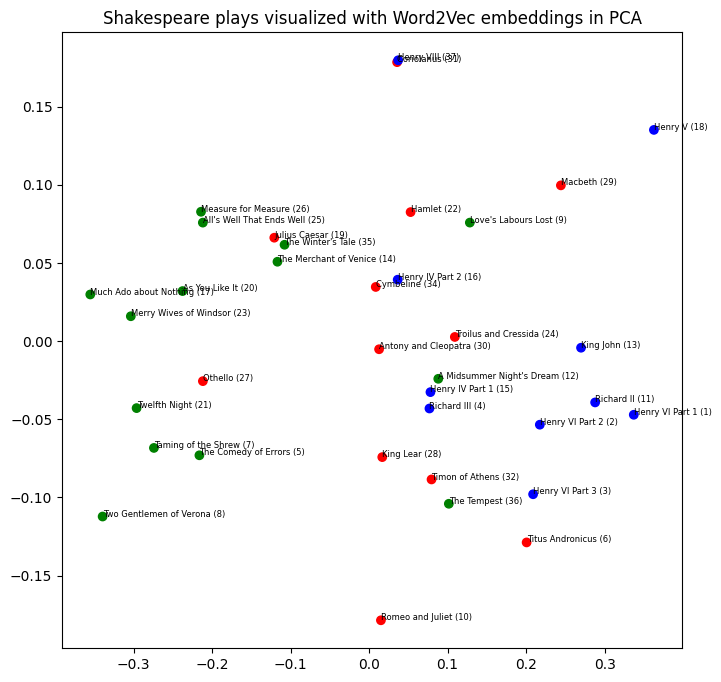

In [55]:
plt.figure(figsize=(8, 8))
plt.title("Shakespeare plays visualized with Word2Vec embeddings in PCA")
colors={'History':'b','Tragedy':'r','Comedy':'g'}
point_colors = [colors[genre] for genre in genres]
plt.scatter(resultwv[:, 0], resultwv[:, 1], c=point_colors)#plot

# Annotate the points with play names and chronological order
for i in range(len(play_names_array)):
    plt.annotate(f"{play_names_array[i]} ({chronology[i]})", (resultwv[i, 0], resultwv[i, 1]), fontsize=6)#annotation

plt.show()

Tried min_counts more than 1 but then it is not getting few words that are used less than min_counts time which makes the model worst.

Tried window count as 1, 5, 10, 15. 5 gives the best grouping among these.

This plot also has almost clear groupings with few data points entering other clusters towards the middle region.

### Part F:  Visualizing the Players using Word2Vec Word Embeddings (8 pts)

Now you must repeat Part C, but using these `Word2Vec` embeddings.

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible.

Again, comment on what you observe. How is this different from what you saw in Part C?


In [56]:
#doc_term_array for player
doc_term_array_wv_player = np.zeros((len(player_names_array), 100))
for pl in range(len(player_names_array)):
  line=player_lines[player_names_array[pl]]
  line=line.lower()#lowercase
  line=re.sub(pattern,"",line)#punctuation removal
  count=len(line.split())
  for i in line.split():
    doc_term_array_wv_player[pl]+=model.wv[i]
  doc_term_array_wv_player[pl]=doc_term_array_wv_player[pl]/count

In [57]:
resultwvplayer = pcawv.fit_transform(doc_term_array_wv_player)

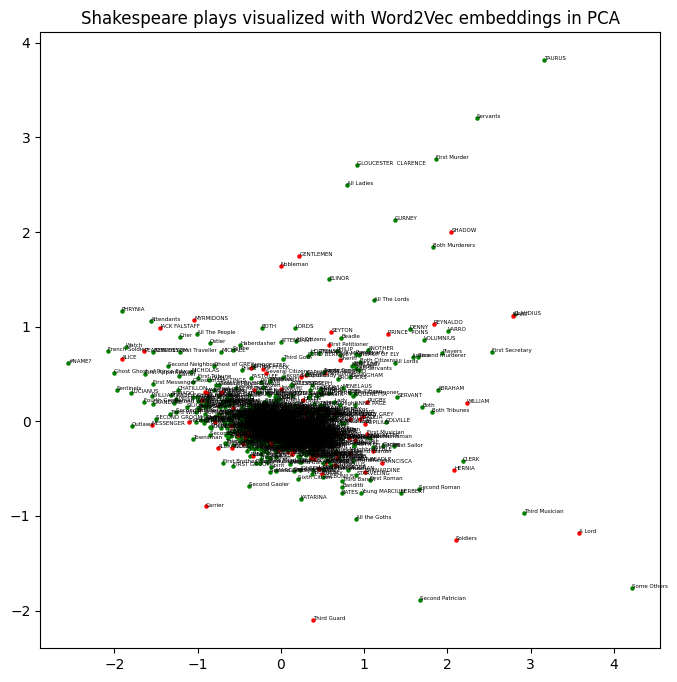

In [59]:
plt.figure(figsize=(8, 8))
plt.title("Shakespeare plays visualized with Word2Vec embeddings in PCA")
for i in range(len(player_names_array)):
    if player_genders[player_names_array[i]]=="male":
      color='g'
    elif player_genders[player_names_array[i]]=="female":
      color='r'
    plt.scatter(resultwvplayer[i, 0], resultwvplayer[i, 1], c=color,s=5)

# Annotate the points with play names and chronological order
for i in range(len(player_names_array)):
    plt.annotate(f"{player_names_array[i]}", (resultwvplayer[i, 0], resultwvplayer[i, 1]), fontsize=4)

plt.show()

This shows similar results to part C before this also clusters around 0 with red data points(female) less spread out than green(male). They have few outliers.

## Problem Two: Classifying Text with a Feed-Forward Neural Network (50 pts)


In this problem, you must create a FFNN in Pytorch to classify emails from the Enron dataset as to whether they
are spam or not spam ("ham"). For this problem, we will use `Glove` pretrained embeddings. The dataset
and the embeddings are in the following location:

https://drive.google.com/drive/folders/1cHR4VJuuN2tEpSkT3bOaGkOJrvIV-lSR?usp=sharing

(You can also download the embeddings yourself from the web; but the dataset is one created
just for this problem.)

### Part A: Prepare the Data (10 pts)

Compute the features of the emails (the vector of 100 floats input to the NN) vector based on the average value of the word vectors that belong to the words in it.

Just like the previous problem, we compute the 'representation' of each message, i.e. the vector, by averaging word vectors; but this time, we are using [Glove word embeddings](https://nlp.stanford.edu/projects/glove/) instead. Specifically, we are using word embedding 'glove.6B.100d' to obtain word vectors of each message, as long as the word is in the 'glove.6B.100d' embedding space.

Here are the steps to follow:

1. Have a [basic idea](https://nlp.stanford.edu/pubs/glove.pdf) of how Glove provides pre-trained word embeddings (vectors).
2. Download and extract word vectors from 'glove.6B.100d'.
3. Tokenize the messages ( `spacy` is a good choice) and compute the message vectors by averaging the vectors of words in the message. You will need to test if a word is in the model (e.g., something like ` if str(word) in glove_model ...`) and ignore any words which have no embeddings.


### Part B: Create the DataLoader (15 pts)

Now you must separate the data set into training, validation, and testing sets, and build a 'Dataset' and 'DataLoader' for each that can feed data to train your model with Pytorch.

Use a train-validation-test split of 80%-10%-10%. You can experiment with different batch sizes, starting with 64.



Hints:
1. Make sure `__init__` , `__len__` and `__getitem__` of the your defined dataset are implemented properly. In particular, the `__getitem__` should return the specified message vector and its label.
2. Don't compute the message vector when calling the `__getitem__` function, otherwise the training process will slow down A LOT. Calculate these in an array before creating the data loader in the next step.
3. The data in the `.csv` is randomized, so you don't need to shuffle when doing the split.

In [60]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
data_dir='/content/drive/MyDrive/CS505 Datasets/'

Mounted at /content/drive


In [61]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = data_dir+'glove.6B/glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

<ipython-input-61-ab1ff4db7141>:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 100)

In [62]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)#glove model loading
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.7698540687561035)]


In [63]:
model['queen']#model testing

array([-0.50045 , -0.70826 ,  0.55388 ,  0.673   ,  0.22486 ,  0.60281 ,
       -0.26194 ,  0.73872 , -0.65383 , -0.21606 , -0.33806 ,  0.24498 ,
       -0.51497 ,  0.8568  , -0.37199 , -0.58824 ,  0.30637 , -0.30668 ,
       -0.2187  ,  0.78369 , -0.61944 , -0.54925 ,  0.43067 , -0.027348,
        0.97574 ,  0.46169 ,  0.11486 , -0.99842 ,  1.0661  , -0.20819 ,
        0.53158 ,  0.40922 ,  1.0406  ,  0.24943 ,  0.18709 ,  0.41528 ,
       -0.95408 ,  0.36822 , -0.37948 , -0.6802  , -0.14578 , -0.20113 ,
        0.17113 , -0.55705 ,  0.7191  ,  0.070014, -0.23637 ,  0.49534 ,
        1.1576  , -0.05078 ,  0.25731 , -0.091052,  1.2663  ,  1.1047  ,
       -0.51584 , -2.0033  , -0.64821 ,  0.16417 ,  0.32935 ,  0.048484,
        0.18997 ,  0.66116 ,  0.080882,  0.3364  ,  0.22758 ,  0.1462  ,
       -0.51005 ,  0.63777 ,  0.47299 , -0.3282  ,  0.083899, -0.78547 ,
        0.099148,  0.039176,  0.27893 ,  0.11747 ,  0.57862 ,  0.043639,
       -0.15965 , -0.35304 , -0.048965, -0.32461 , 

In [64]:
emails_raw=pd.read_csv(data_dir+'data_pa5/enron_spam_ham.csv').to_numpy()#emails data

In [65]:
emails_raw[0]

array(["Subject: sevil yamin  anne ,  vasant sent this information to norma . i shall fwd his message to you .  vince  - - - - - - - - - - - - - - - - - - - - - - forwarded by vince j kaminski / hou / ect on 04 / 10 / 2001  03 : 02 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  stinson gibner  04 / 10 / 2001 02 : 57 pm  to : vince j kaminski / hou / ect @ ect  cc :  subject : sevil yamin  vince ,  do you want me to do this , or vasant ?  - - stinson  - - - - - - - - - - - - - - - - - - - - - - forwarded by stinson gibner / hou / ect on 04 / 10 / 2001  02 : 57 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  from : anne labbe / enron @ enronxgate on 04 / 06 / 2001 09 : 57 am  to : stinson gibner / hou / ect @ ect  cc :  subject : sevil yamin  stinson ,  i am the new hr generalist for the research group because norma villarreal is  moving to business analysis and reporting . earlier this week , norma and i  met with vince , and he said that he was going to talk to you

In [66]:
print(emails_raw.shape)

(28138, 2)


In [67]:
import spacy
sp=spacy.load('en_core_web_sm')

text,label=emails_raw[0]
print(text)
document=sp(text.lower())#spacy test

for word in document:
  print(str(word))
  break

Subject: sevil yamin  anne ,  vasant sent this information to norma . i shall fwd his message to you .  vince  - - - - - - - - - - - - - - - - - - - - - - forwarded by vince j kaminski / hou / ect on 04 / 10 / 2001  03 : 02 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  stinson gibner  04 / 10 / 2001 02 : 57 pm  to : vince j kaminski / hou / ect @ ect  cc :  subject : sevil yamin  vince ,  do you want me to do this , or vasant ?  - - stinson  - - - - - - - - - - - - - - - - - - - - - - forwarded by stinson gibner / hou / ect on 04 / 10 / 2001  02 : 57 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  from : anne labbe / enron @ enronxgate on 04 / 06 / 2001 09 : 57 am  to : stinson gibner / hou / ect @ ect  cc :  subject : sevil yamin  stinson ,  i am the new hr generalist for the research group because norma villarreal is  moving to business analysis and reporting . earlier this week , norma and i  met with vince , and he said that he was going to talk to you about w

In [68]:
type(document)

spacy.tokens.doc.Doc

In [69]:
type(word)

spacy.tokens.token.Token

In [70]:
model[str(word)]#model test

array([-0.098252 ,  0.053359 ,  0.3814   ,  0.25006  ,  0.37622  ,
        0.39795  , -0.42648  , -0.11512  , -0.062542 , -0.30872  ,
       -0.1126   ,  0.017485 ,  0.42269  , -0.05028  , -0.036123 ,
       -0.17231  ,  0.022046 ,  0.269    , -0.23359  ,  0.012059 ,
       -0.17243  , -0.204    , -0.0737   , -0.11341  ,  0.11035  ,
       -0.56162  ,  0.080746 , -0.36331  , -0.30045  , -0.12815  ,
       -0.45184  ,  0.012891 , -0.1789   , -0.44184  ,  0.093577 ,
        0.59694  ,  0.023494 , -0.4611   , -0.45794  ,  0.11821  ,
       -0.5165   , -0.11584  ,  0.083922 ,  0.016293 , -0.25888  ,
       -0.30356  ,  0.28238  , -0.031084 ,  0.045921 , -0.65211  ,
        0.98727  ,  0.023694 ,  0.22667  ,  0.75697  , -0.20568  ,
       -1.3769   ,  0.41452  , -0.54832  ,  1.5247   ,  0.16025  ,
        0.35099  ,  0.99004  , -0.32081  , -0.51617  ,  1.7852   ,
       -0.36472  ,  0.52039  , -0.0099243,  0.066323 ,  0.073432 ,
       -0.40247  ,  0.04315  ,  0.49818  ,  0.50381  , -0.3044

In [74]:
#Emails token generation with spacy
emails_token=np.empty((28138,),dtype=object)
for index,(text,label) in enumerate(emails_raw):
  document=sp(text.lower())
  emails_token[index]=np.array((document,label))


<ipython-input-74-e78390910846>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  emails_token[index]=np.array((document,label))


In [75]:
#Email token storing in a csv file for future runs
import csv
with open('emails_token.csv', 'w', newline='') as file:
     writer = csv.writer(file)
     writer.writerows(emails_token)

In [76]:
#(Text embedding, label data creation)
emails_new=np.empty((28138,),dtype=object)
#text_emb = np.zeros((28138, 100), dtype=np.float32)
#raw_list=list(sp.pipe(emails_raw, n_process=1))
for index,(text,label) in enumerate(emails_token):
  count=0
  text_emb=np.zeros(100,dtype=np.float32)
  for word in emails_token[index][0]:
    if str(word) in model:
      text_emb+=model[str(word)]#text embeddings from model
      count+=1
    emails_new[index]=np.array((text_emb/count,label))#Mean test embedding,label


<ipython-input-76-542605166564>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  emails_new[index]=np.array((text_emb/count,label))#Mean test embedding,label


In [77]:
x_s=[subarray[0] for subarray in emails_new]#Text Embeddings
y_s=[subarray[1] for subarray in emails_new]#Labels

In [78]:
class EmailDataset(Dataset):

    def __init__(self, X,Y):
        self.X_emails = X
        self.Y_emails = Y

    def __len__(self):
        return len(self.X_emails)

    # return a pair x,y at the index idx in the data set
    def __getitem__(self, idx):
        return self.X_emails[idx], self.Y_emails[idx]

In [79]:
#Training, test, validation set creation
batch_size = 64

emails_ds = EmailDataset(x_s,y_s)

gen = torch.Generator().manual_seed(0)  # this will ensure the same split every time

train_emails_ds,val_emails_ds,test_emails_ds = random_split(emails_ds, [0.8,0.1,0.1], generator=gen)

emails_training_dataloader =   DataLoader(train_emails_ds, batch_size=batch_size, shuffle=False)

emails_validation_dataloader = DataLoader(val_emails_ds,   batch_size=batch_size, shuffle=False)

emails_testing_dataloader =    DataLoader(test_emails_ds,  batch_size=batch_size, shuffle=False)

In [80]:
print(test_emails_ds[0])#test set format test

(array([-9.1352448e-02,  2.5194323e-01,  3.3864340e-01, -2.8265482e-01,
       -2.0433996e-02,  1.4141363e-01, -9.0096027e-02,  1.7112041e-01,
       -6.2731616e-02,  1.7836126e-02,  3.0337977e-01, -2.2831915e-02,
        1.7594045e-01,  1.2013896e-01,  1.4919332e-01, -3.7911835e-01,
        2.0489813e-01, -2.0775763e-02, -4.1122207e-01,  2.5491598e-01,
        1.0109802e-01,  7.2729848e-02,  1.3074291e-01,  1.6886656e-01,
        2.4896729e-01,  2.8315708e-02,  1.1340470e-02, -3.3072284e-01,
        1.0222283e-01, -1.7407700e-01, -3.4149759e-02,  4.4460675e-01,
        1.2854139e-02, -3.9066449e-03, -6.7685634e-02,  2.0037954e-01,
        2.3316259e-02,  2.9758182e-01, -1.8326811e-02, -1.4598313e-01,
       -2.8329211e-01, -3.0654433e-01,  7.0601992e-02, -3.4519550e-01,
       -1.0354839e-01, -7.0377849e-02,  2.1241825e-02, -3.8182405e-01,
       -3.4659583e-02, -6.5811437e-01,  1.3443315e-03, -6.9950456e-03,
        1.6808799e-01,  8.9009666e-01, -3.3068210e-01, -2.0843985e+00,
     

### Part C:  Build the neural net model (25 pts)

Once the data is ready, we need to design and implement our neural network model.

The model does not need to be complicated. An example structure could be:

1. linear layer 100 x 15
2. ReLU activation layer
3. linear layer 15 x 2

But feel free to test out other possible combinations of linear layers & activation function and whether they make significant difference to the model performance later.

In order to perform "early stopping," you must keep track of the best validation score as you go through the epochs, and
save the best model generated so far; then use the model which existed when the validation score
was at a minimum to do the testing. (This could also be the model which is deployed, although we won't
worry about that.) Read about `torch.save(...)` and `torch.load(...)` to do this.

Experiment with different batch sizes and optimizers and learning rates to get the best validation
score for the model you create with early stopping. (Try not to look *too hard* at the final accuracy!) Include your final performance charts (using `show_performance_curves`) when you submit.

Conclude with a brief analysis (a couple of sentences is fine) relating what experiments you did,
and what choices of geometry, optimizer, learning rate, and batch size gave you the best results.
It should not be hard to get well above 90% accuracy on the final test.

In [81]:
#Basic suggested model
class EmailsModel(nn.Module):

        # We first define a number of local variables for layers

        def __init__(self):
            super(EmailsModel, self).__init__()
            self.fc1 = nn.Linear(100, 15)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(15, 2)

        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x


In [82]:
#Improvised Model
class EmailsModel2(nn.Module):

        # We first define a number of local variables for layers

        def __init__(self):
            super(EmailsModel2, self).__init__()
            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(100, 64)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(64, 2)

        def forward(self, x):
            x = self.flatten(x)
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x

In [83]:
#Basic Model Training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
print()

best_val_loss = float('inf')
best_model_state = None
emails_model2 = EmailsModel().to(device)                     # <<====

# print(blobs_model)

loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.SGD(emails_model2.parameters(),lr=0.001)
#optimizer = optim.Adam(emails_model2.parameters(),lr=0.001)
optimizer = optim.Adagrad(emails_model2.parameters(),lr=0.01)
# optimizer = optim.RMSprop(blobs_model2.parameters(),lr=0.001)

num_epochs = 100

batch_size = 64

training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

for epoch in tqdm(range(num_epochs)):
    # training
    emails_model2.train()
    t_loss = 0.0
    t_num_correct = 0

    for X_train_batch,Y_train_batch in emails_training_dataloader:
        X_train_batch = X_train_batch.to(device)                     # <<====
        Y_train_batch = Y_train_batch.to(device)                     # <<====

        optimizer.zero_grad
        Y_train_hat = emails_model2(X_train_batch)
        loss = loss_fn(Y_train_hat,Y_train_batch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

        # If we just use the scalar class number, it must be a long (we did this when creating the dataset)
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == Y_train_batch).float().sum()

    training_losses[epoch]   = t_loss/len(train_emails_ds)
    training_accuracy[epoch] = t_num_correct/len(train_emails_ds)

    #  validation
    v_loss = 0.0
    emails_model2.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in emails_validation_dataloader:
        X_val_batch = X_val_batch.to(device)                     # <<====
        Y_val_batch = Y_val_batch.to(device)                     # <<====

        Y_hat_val = emails_model2(X_val_batch)
        loss = loss_fn(Y_hat_val,Y_val_batch)
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == Y_val_batch).float().sum()

    val_losses[epoch]   = v_loss/len(val_emails_ds)
    val_accuracy[epoch] = v_num_correct/len(val_emails_ds)
    if val_losses[epoch] < best_val_loss:#Early stopping for best validation loss
      best_val_loss = val_losses[epoch]
      best_model_state = emails_model2.state_dict()
    if best_model_state is not None:
      torch.save(best_model_state, 'best_model2.pth')



Using cpu



100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


In [84]:
#Improvised Model training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
print()

best_val_loss = float('inf')
best_model_state = None
emails_model3 = EmailsModel2().to(device)                     # <<====

# print(blobs_model)

loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.SGD(emails_model2.parameters(),lr=0.001)
#optimizer = optim.Adam(emails_model3.parameters(),lr=0.001)
optimizer = optim.Adagrad(emails_model3.parameters(),lr=0.01)
# optimizer = optim.RMSprop(blobs_model2.parameters(),lr=0.001)

num_epochs = 100

batch_size = 64

training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

for epoch in tqdm(range(num_epochs)):
    # training
    emails_model2.train()
    t_loss = 0.0
    t_num_correct = 0

    for X_train_batch,Y_train_batch in emails_training_dataloader:
        X_train_batch = X_train_batch.to(device)                     # <<====
        Y_train_batch = Y_train_batch.to(device)                     # <<====

        optimizer.zero_grad
        Y_train_hat = emails_model3(X_train_batch)
        loss = loss_fn(Y_train_hat,Y_train_batch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

        # If we just use the scalar class number, it must be a long (we did this when creating the dataset)
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == Y_train_batch).float().sum()

    training_losses[epoch]   = t_loss/len(train_emails_ds)
    training_accuracy[epoch] = t_num_correct/len(train_emails_ds)

    #  validation
    v_loss = 0.0
    emails_model3.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in emails_validation_dataloader:
        X_val_batch = X_val_batch.to(device)                     # <<====
        Y_val_batch = Y_val_batch.to(device)                     # <<====

        Y_hat_val = emails_model3(X_val_batch)
        loss = loss_fn(Y_hat_val,Y_val_batch)
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == Y_val_batch).float().sum()

    val_losses[epoch]   = v_loss/len(val_emails_ds)
    val_accuracy[epoch] = v_num_correct/len(val_emails_ds)
    if val_losses[epoch] < best_val_loss:#Early stopping for best validation loss
      best_val_loss = val_losses[epoch]
      best_model_state = emails_model3.state_dict()
    if best_model_state is not None:
      torch.save(best_model_state, 'best_model3.pth')


Using cpu



100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


In [85]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss,label='Training',color='g')
    plt.plot(validation_loss,label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
#     plt.ylim(-0.1,(max(max(training_loss),max(validation_loss))*1.1) )
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[-1],6))
    print('Final Validation Loss:',np.around(validation_loss[-1],6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy,label='Training',color='g')
    plt.plot(validation_accuracy,label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
#     plt.ylim(-0.1,1.1)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print('Final Training Accuracy:  ',np.around(training_accuracy[-1],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[-1],6))
    print()

    print("Test Accuracy:", np.around(test_accuracy.item(),4))

    print()

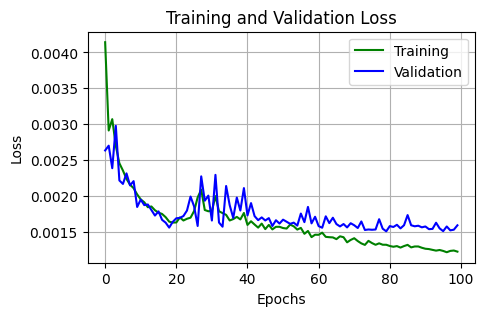

Final Training Loss:   0.001224
Final Validation Loss: 0.001591


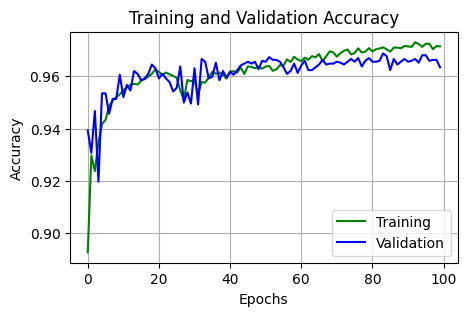

Final Training Accuracy:   0.971392
Final Validation Accuracy: 0.963397

Test Accuracy: 0.9531



In [91]:
#Base Model Evaluation
model_state_dict = torch.load("best_model2.pth")

emails_model = EmailsModel()
emails_model.to(device)

emails_model.load_state_dict(model_state_dict)

emails_model.eval()

num_correct_test = 0

for X_test_batch, Y_test_batch in emails_testing_dataloader:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)

    with torch.no_grad():
        Y_hat_test = emails_model(X_test_batch)

    num_correct_test += (torch.argmax(Y_hat_test, dim=1) == Y_test_batch).float().sum()

test_accuracy = num_correct_test / len(test_emails_ds)

show_performance_curves(training_losses, val_losses, training_accuracy, val_accuracy, test_accuracy)

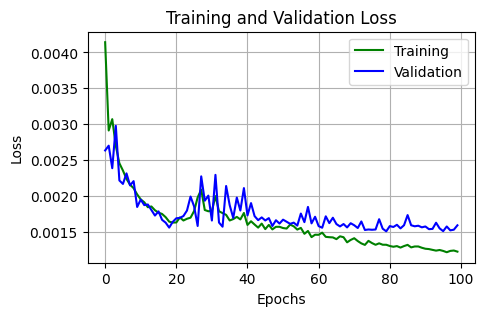

Final Training Loss:   0.001224
Final Validation Loss: 0.001591


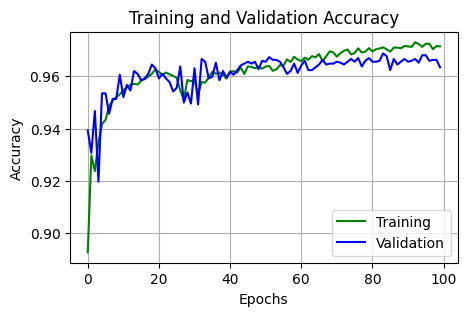

Final Training Accuracy:   0.971392
Final Validation Accuracy: 0.963397

Test Accuracy: 0.9616



In [90]:
#Modified model evaluation
model_state_dict = torch.load("best_model3.pth")


emails_model2 = EmailsModel2()
emails_model2.to(device)

emails_model2.load_state_dict(model_state_dict)


emails_model2.eval()

num_correct_test = 0

for X_test_batch, Y_test_batch in emails_testing_dataloader:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)

    with torch.no_grad():
        Y_hat_test = emails_model2(X_test_batch)

    num_correct_test += (torch.argmax(Y_hat_test, dim=1) == Y_test_batch).float().sum()

test_accuracy = num_correct_test / len(test_emails_ds)

show_performance_curves(training_losses, val_losses, training_accuracy, val_accuracy, test_accuracy)

Results:
Architecture Trials: Tried using different choice for hidden layers, activation functions like sigmoid etc but the setup with 100,64,2 and ReLU worked best.

Optimizer and Learning Rate trials: Tried using SGD, Adam, Adagrad and RMSProp optimizers with different learning rates.

Trained the models and saved the model with best validation loss.

Both the models get a good accuracy of 95.31 and 96.16\%.